# Matrix multiplication from scratch
In this series, we implement matrix multiplication from scratch. We are only allowed to use:
- python
- python standard library
- matplotlib
- Jupyter notebooks
However, once we have implemented a feature from scratch, we can use its Numpy/PyTorch equivalent.

In [2]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt     

## Get data
We use the Fashion-MNIST in this notebook.

In [3]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [4]:
X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')

In [5]:
type(X_train)

numpy.ndarray

Since we are not allowed to use Numpy (yet), let's typecast the Numpy arrays back to lists.

In [6]:
X_train, y_train = list(X_train), list(y_train)
X_test, y_test = list(X_test), list(y_test)

In [7]:
len(X_train)

60000

In [8]:
len(X_train[0])

784

In [9]:
img = list(X_train[0])
type(img)

list

We have 60k images that are 784 (28*28) pixels each.

## Create iterators to convert 1D list (784) to 2D image (28 by 28)
We shall implement this using 2 methods:
1. `yield`
2. `itertools` `islice`

### `yield`

In [10]:
def chunks(arr, length):
    for i in range(0, len(arr), length):
        yield arr[i: i+length]

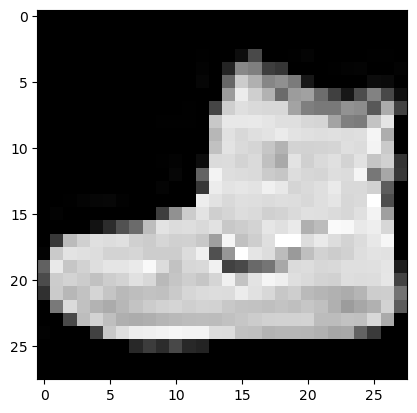

In [11]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(img, 28)))

### `islice`

In [12]:
from itertools import islice

In [13]:
img_iter = iter(img)

In [14]:
list(islice(img_iter, 28))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [15]:
list(islice(img_iter, 28))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [16]:
list(islice(img_iter, 28))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [17]:
list(islice(img_iter, 28))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 13,
 73,
 0,
 0,
 1,
 4,
 0,
 0,
 0,
 0,
 1,
 1,
 0]

We see that `islice` is working properly.

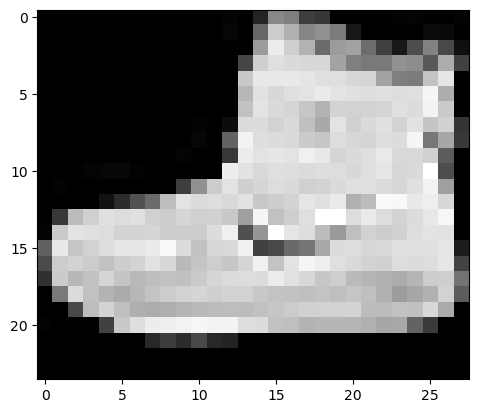

In [18]:
reshaped_img = list(iter(lambda: list(islice(img_iter, 28)), []))
plt.imshow(reshaped_img)

Now that we can reshape our python lists from 1D to 2D, we shall move on to implementing a Matrix class.

## Implementing Matrix class

In [19]:
class Matrix:
    def __init__(self, mat): self.mat = mat
    def __getitem__(self, idx): 
        i, j = idx
        return self.mat[i][j]

In [20]:
img_mat = Matrix(reshaped_img)

In [21]:
img_mat[7, 15]

212

We can now use PyTorch's tensor.

In [22]:
from torch import tensor

In [23]:
X_train, y_train, X_test, y_test = map(tensor, (X_train, y_train, X_test, y_test))

/var/folders/9w/n7wj1hcx50l_4wy5p7w741080000gn/T/ipykernel_4193/4132864298.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  X_train, y_train, X_test, y_test = map(tensor, (X_train, y_train, X_test, y_test))


In [24]:
X_train.shape

torch.Size([60000, 784])

In [25]:
X_train = X_train.reshape(-1, 28, 28)

In [26]:
X_train.shape

torch.Size([60000, 28, 28])

## Wichmann Hill random number generator
Wichmann Hill algorithm requires 3 numbers as seed. We shall use the current time to set those seed numbers.

In [27]:
# LCG parameters (adjust as needed)
a = 1664525
c = 1013904223
m = 2**32

global s1, s2, s3
# Initialize a single seed (you can use the seed initialization methods mentioned earlier)
initial_seed = 69

# Function to generate three distinct seeds
def generate_seeds(seed, count):
    seeds = []
    for _ in range(count):
        seed = (a * seed + c) % m
        seeds.append(seed % 30000 + 1)
    return seeds

# Generate three distinct seeds
s1, s2, s3 = generate_seeds(initial_seed, 3)

In [28]:
print(s1, s2, s3)

6449 1632 15443


In [29]:
# Wichmann Hill algorithm
def random_number():
    global s1, s2, s3
    s1 = (171 * s1) % 30269
    s2 = (172 * s2) % 30307
    s3 = (170 * s3) % 30323

    return (s1 / 30269.0 + s2 / 30307.0 + s3 / 30323.0) % 1

In [30]:
random_number()

0.2728144914355908

In [31]:
random_number()

0.3351217283531356

(array([ 983.,  988., 1040., 1024.,  960.,  986., 1049.,  978., 1007.,
         985.]),
 array([1.32909738e-05, 1.00006960e-01, 2.00000629e-01, 2.99994298e-01,
        3.99987967e-01, 4.99981636e-01, 5.99975305e-01, 6.99968974e-01,
        7.99962643e-01, 8.99956312e-01, 9.99949981e-01]),
 <BarContainer object of 10 artists>)

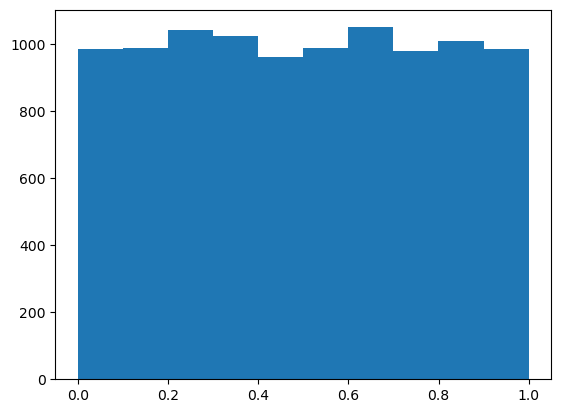

In [32]:
plt.hist([random_number() for _ in range(10000)])

We want to compare the speed difference in our implementation of random number generation and forming a matrix vs PyTorch's.

In [33]:
%timeit -n 10 list(chunks([random_number() for _ in range(7840)], 10))

1.72 ms ± 53.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
import torch

In [35]:
%timeit -n 10 torch.randn(784,10)

99 µs ± 39.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We see that our implementation is approximately 1000 times slower!

## Matrix multiplication
Now that we have figured out how to load our own matrices, it's time to learn how to implement matrix multiplication from scratch.

In [36]:
m1 = X_train[:5]
type(m1)

torch.Tensor

In [37]:
m1.shape

torch.Size([5, 28, 28])

Let's flatten the array for the purpose of this section.

In [38]:
m1 = m1.reshape(m1.shape[0], -1)
m1.shape

torch.Size([5, 784])

In [39]:
# assume there are 10 outcomes
weights = torch.randn((784, 10))
m2 = weights

### Naive matrix multiplication
Let's start with the most naive matrix multiplication, a n^3 iteration.

In [40]:
def naive_mat_mul(m1, m2):
    ar, ac = m1.shape[0], m1.shape[1]
    br, bc = m2.shape[0], m2.shape[1]
    out = torch.zeros((ar, bc))

    for i in range(ar):
        for j in range(ac):
            for k in range(bc):
                out[i, k] += m1[i, j] * m2[j, k]

    return out

In [41]:
out = naive_mat_mul(m1, m2)
out

tensor([[  825.7801, -5119.0200, -3030.0803,  8452.5508, -1708.8137,  4967.5967,
         -3117.9248,  3927.7046,  7520.3359,  2714.1130],
        [ 3257.3381, -7608.4561, -3939.4231,  5816.7822,  -793.9747,  4091.6438,
         -6302.0020,  4591.6201,  6519.3906, -1864.9594],
        [ 2518.8491,  -612.1136, -2174.3574,  2077.1423, -1485.0481,   774.2585,
         -2714.1323,  1817.2858,  2972.8625, -1444.4025],
        [ 1970.8092, -2111.0867, -3197.2397,  2598.4731, -1814.3883,  2991.3188,
         -2650.9753,  2800.6914,  3939.0605, -1780.9260],
        [ 3196.2400, -3053.1538, -4891.3228,  2810.9255, -2079.3650,  2528.6565,
         -5266.2329,  3704.8628,  3660.6160, -4744.5791]])

Let's time this naive implementation.

In [42]:
%time _ = naive_mat_mul(m1, m2)

CPU times: user 439 ms, sys: 2.56 ms, total: 441 ms
Wall time: 441 ms


This is slow! It took about half a second.

### Numba
Let's try to use numba for the dot product.

In [43]:
from numba import jit
import numpy as np

In [44]:
@jit(nopython=True)
def dot(a, b):
    total = 0
    for i in range(len(a)):
        total += a[i] * b[i]

    return total

In [45]:
m2[:, 1].shape

torch.Size([784])

In [46]:
def numba_mat_mul(m1, m2):
    ar, ac = m1.shape[0], m1.shape[1]
    br, bc = m2.shape[0], m2.shape[1]
    out = torch.zeros((ar, bc))

    for i in range(ar):
        for k in range(bc):
            out[i, k] = dot(m1[i].numpy(), m2[:, k].numpy())

    return out

In [47]:
out2 = numba_mat_mul(m1, m2)

In [48]:
out2

tensor([[  825.7802, -5119.0200, -3030.0796,  8452.5527, -1708.8137,  4967.5972,
         -3117.9241,  3927.7056,  7520.3369,  2714.1133],
        [ 3257.3413, -7608.4575, -3939.4231,  5816.7837,  -793.9749,  4091.6440,
         -6302.0034,  4591.6201,  6519.3940, -1864.9586],
        [ 2518.8486,  -612.1138, -2174.3591,  2077.1433, -1485.0482,   774.2588,
         -2714.1311,  1817.2854,  2972.8635, -1444.4021],
        [ 1970.8087, -2111.0872, -3197.2393,  2598.4736, -1814.3889,  2991.3188,
         -2650.9753,  2800.6912,  3939.0613, -1780.9260],
        [ 3196.2412, -3053.1541, -4891.3228,  2810.9258, -2079.3655,  2528.6555,
         -5266.2310,  3704.8618,  3660.6145, -4744.5786]])

In [49]:
%time _ = numba_mat_mul(m1, m2)

CPU times: user 1.08 ms, sys: 1.15 ms, total: 2.23 ms
Wall time: 1.3 ms


We see a speed up of close to 200 times!

### Pytorch `sum` and `dot`

In [50]:
(m1[0] * m2[:, 0]).shape

torch.Size([784])

In [51]:
def sum_mat_mul(m1, m2):
    ar, ac = m1.shape[0], m1.shape[1]
    br, bc = m2.shape[0], m2.shape[1]
    out = torch.zeros((ar, bc))

    for i in range(ar):
        for k in range(bc):
            out[i, k] = (m1[i] * m2[:, k]).sum()

    return out

In [52]:
out3 = sum_mat_mul(m1, m2)
out3

tensor([[  825.7804, -5119.0186, -3030.0796,  8452.5527, -1708.8136,  4967.5977,
         -3117.9243,  3927.7058,  7520.3369,  2714.1133],
        [ 3257.3416, -7608.4570, -3939.4224,  5816.7842,  -793.9750,  4091.6440,
         -6302.0034,  4591.6206,  6519.3936, -1864.9584],
        [ 2518.8486,  -612.1138, -2174.3591,  2077.1436, -1485.0482,   774.2590,
         -2714.1313,  1817.2854,  2972.8635, -1444.4020],
        [ 1970.8088, -2111.0872, -3197.2397,  2598.4736, -1814.3889,  2991.3188,
         -2650.9756,  2800.6912,  3939.0613, -1780.9263],
        [ 3196.2407, -3053.1543, -4891.3228,  2810.9258, -2079.3657,  2528.6560,
         -5266.2314,  3704.8623,  3660.6147, -4744.5791]])

In [53]:
%time _ = sum_mat_mul(m1, m2)

CPU times: user 2.02 ms, sys: 1.26 ms, total: 3.28 ms
Wall time: 2.39 ms


This is faster than our numba implementation, although that may have been slowed down by calling `.numpy()` repeatedly in the inner loop.

In [54]:
def dot_mat_mul(m1, m2):
    ar, ac = m1.shape[0], m1.shape[1]
    br, bc = m2.shape[0], m2.shape[1]
    out = torch.zeros((ar, bc))

    for i in range(ar):
        for k in range(bc):
            out[i, k] = torch.dot(m1[i].float(),  m2[:, k])

    return out

In [55]:
out4 = dot_mat_mul(m1, m2)
out4

tensor([[  825.7800, -5119.0195, -3030.0791,  8452.5518, -1708.8132,  4967.5977,
         -3117.9241,  3927.7041,  7520.3379,  2714.1138],
        [ 3257.3423, -7608.4585, -3939.4219,  5816.7842,  -793.9749,  4091.6438,
         -6302.0039,  4591.6196,  6519.3945, -1864.9591],
        [ 2518.8481,  -612.1136, -2174.3594,  2077.1433, -1485.0482,   774.2589,
         -2714.1311,  1817.2855,  2972.8638, -1444.4021],
        [ 1970.8088, -2111.0869, -3197.2390,  2598.4739, -1814.3887,  2991.3193,
         -2650.9756,  2800.6912,  3939.0618, -1780.9270],
        [ 3196.2412, -3053.1536, -4891.3223,  2810.9253, -2079.3652,  2528.6567,
         -5266.2305,  3704.8618,  3660.6147, -4744.5781]])

In [56]:
%time _ = dot_mat_mul(m1, m2)

CPU times: user 1.86 ms, sys: 1.48 ms, total: 3.34 ms
Wall time: 2.59 ms


### Broadcasting
Now let's try broadcasting where we only have 1 outer loop.

In [57]:
m1[0].shape

torch.Size([784])

In [58]:
m2_transposed = torch.transpose(m2, 1, 0)
m2_transposed.shape

torch.Size([10, 784])

In [59]:
(m1[0] * m2_transposed).shape

torch.Size([10, 784])

In [60]:
(m1[0] * m2_transposed).sum(axis = 1)

tensor([  825.7808, -5119.0200, -3030.0806,  8452.5527, -1708.8138,  4967.5967,
        -3117.9238,  3927.7053,  7520.3379,  2714.1138])

In [61]:
def broadcast_mat_mul(m1, m2):
    ar, ac = m1.shape[0], m1.shape[1]
    br, bc = m2.shape[0], m2.shape[1]
    out = torch.zeros((ar, bc))

    m2_transposed = torch.transpose(m2, 1, 0)
    for i in range(ar):
        out[i] = (m1[i] * m2_transposed).sum(axis=1)

    return out

In [62]:
out5 = broadcast_mat_mul(m1, m2)
out5

tensor([[  825.7808, -5119.0200, -3030.0806,  8452.5527, -1708.8138,  4967.5967,
         -3117.9238,  3927.7053,  7520.3379,  2714.1138],
        [ 3257.3413, -7608.4580, -3939.4224,  5816.7832,  -793.9751,  4091.6443,
         -6302.0044,  4591.6201,  6519.3931, -1864.9583],
        [ 2518.8486,  -612.1140, -2174.3594,  2077.1433, -1485.0486,   774.2588,
         -2714.1309,  1817.2853,  2972.8635, -1444.4021],
        [ 1970.8086, -2111.0872, -3197.2400,  2598.4736, -1814.3889,  2991.3188,
         -2650.9749,  2800.6909,  3939.0613, -1780.9260],
        [ 3196.2417, -3053.1536, -4891.3228,  2810.9258, -2079.3657,  2528.6560,
         -5266.2314,  3704.8618,  3660.6147, -4744.5781]])

In [63]:
%time _ = broadcast_mat_mul(m1, m2)

CPU times: user 480 µs, sys: 624 µs, total: 1.1 ms
Wall time: 584 µs


### Einstein summation

In [64]:
def einsum_mat_mul(a, b):
    return torch.einsum('ij,jk->ik', a, b)

In [69]:
m2.shape

torch.Size([784, 10])

In [67]:
out6 = einsum_mat_mul(m1.float(), m2.float())
out6

tensor([[  825.7798, -5119.0195, -3030.0803,  8452.5508, -1708.8147,  4967.5957,
         -3117.9253,  3927.7041,  7520.3359,  2714.1133],
        [ 3257.3391, -7608.4556, -3939.4231,  5816.7812,  -793.9745,  4091.6443,
         -6302.0020,  4591.6206,  6519.3896, -1864.9598],
        [ 2518.8494,  -612.1133, -2174.3584,  2077.1428, -1485.0483,   774.2583,
         -2714.1323,  1817.2858,  2972.8625, -1444.4025],
        [ 1970.8090, -2111.0872, -3197.2400,  2598.4736, -1814.3888,  2991.3193,
         -2650.9756,  2800.6917,  3939.0610, -1780.9263],
        [ 3196.2397, -3053.1536, -4891.3242,  2810.9253, -2079.3645,  2528.6555,
         -5266.2324,  3704.8621,  3660.6162, -4744.5791]])

In [71]:
m1 = m1.float()
m2 = m2.float()

In [72]:
%time _ = einsum_mat_mul(m1, m2)

CPU times: user 360 µs, sys: 229 µs, total: 589 µs
Wall time: 365 µs


Now this is faster than using broadcasting to do our matrix multiplication! We can also use PyTorch's in-built `@` or `torch.matmul`.

In [73]:
%time _ = m1@m2

CPU times: user 372 µs, sys: 433 µs, total: 805 µs
Wall time: 384 µs


In [74]:
%time _ = torch.matmul(m1, m2)

CPU times: user 194 µs, sys: 80 µs, total: 274 µs
Wall time: 251 µs


Surprisingly, `torch.matmul` is the fastest thus far. Now let's try to use CUDA to speed things up via parallelisation.

## CUDA
The fundamental idea behind CUDA/parallelisation is that we can see matrix multiplication of 2 matrices as finding a single element of the output matrix (i, j) at one time. Then, we parallelise finding a single element (i.e. computing each element in parallel).

In [77]:
def cuda_sim_mat_mul(grid, a, b, c):
    i, j = grid # destructuring
    if i < a.shape[0] and j < b.shape[1]:
        tmp = 0.0
        for k in range(a.shape[1]):
            tmp += a[i, k] * b[k, j]

        c[i, j] = tmp

In [78]:
out7 = torch.zeros((m1.shape[0], m2.shape[1]))
cuda_sim_mat_mul((0,0), m1, m2, out7)
out7

tensor([[825.7801,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000]])

Yep, it is working correctly for our first element. Now we need to do this in parallel. To do so, we need a Nvidia GPU.

In [80]:
from numba import cuda

In [81]:
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [ ]:
out8 = torch.zeros((m1.shape[0], m2.shape[1]))
m1c, m2c, out8c = map(cuda.to_device, (m1, m2, out8))